In [1]:
import hopsworks
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os


/home/jdowling/anaconda3/envs/book/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://snurran.hops.works:443/p/5240
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view

titanic_fg = fs.get_feature_group(name="titanic", version=1)
selected_features = titanic_fg.select_all()

label_encoder = fs.get_transformation_function(name="label_encoder")

encode_categoricals = {
    "sex": label_encoder,
    "embarked": label_encoder,
}

feature_view = fs.get_or_create_feature_view(name="titanic",
                                  version=1,
                                  description="Read from Titanic Passengers Dataset",
                                  labels=["survived"],
                                  transformation_functions=encode_categoricals,
                                  query=selected_features)

Feature view created successfully, explore it at 
https://snurran.hops.works:443/p/5240/fs/5188/fv/titanic/version/1


In [4]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

X_train

Finished: Reading data from Hopsworks, using Hive (2.31s) 


,sex,age,pclass,fare,parch,sibsp,embarked
0,0,28.000000,2,13.0000,0,0,0
1,1,18.000000,2,23.0000,1,0,0
2,1,29.699118,3,7.2292,0,0,1
3,0,22.000000,1,135.6333,0,0,1
4,0,4.000000,3,31.2750,2,4,0
...,...,...,...,...,...,...,...
758,0,70.000000,2,10.5000,0,0,0
759,1,41.000000,1,134.5000,0,0,1
760,1,30.000000,1,106.4250,0,0,1
762,0,18.000000,3,7.7750,0,0,0


In [5]:
# Train our model with XGBoost Classifier
model = xgb.XGBClassifier()
model.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [6]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)
y_pred

array([1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0])

In [7]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
metrics

{'0': {'precision': 0.7789473684210526,
  'recall': 0.8409090909090909,
  'f1-score': 0.8087431693989071,
  'support': 88.0},
 '1': {'precision': 0.7586206896551724,
  'recall': 0.676923076923077,
  'f1-score': 0.7154471544715447,
  'support': 65.0},
 'accuracy': 0.7712418300653595,
 'macro avg': {'precision': 0.7687840290381125,
  'recall': 0.758916083916084,
  'f1-score': 0.7620951619352259,
  'support': 153.0},
 'weighted avg': {'precision': 0.770311851298293,
  'recall': 0.7712418300653595,
  'f1-score': 0.7691076075016617,
  'support': 153.0}}

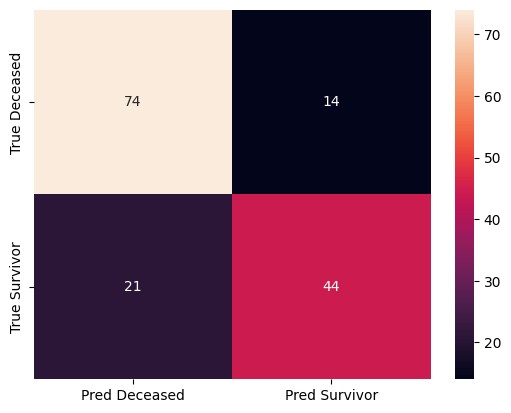

In [8]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Deceased', 'True Survivor'],
                     ['Pred Deceased', 'Pred Survivor'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

fig.show()

In [9]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="titanic_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if os.path.isdir(images_dir) == False:
    os.mkdir(images_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/titanic_model.pkl")
fig.savefig(images_dir + "/confusion_matrix.png")    


# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
titanic_model = mr.python.create_model(
    name="titanic", 
    metrics={"accuracy" : metrics['accuracy'], 
             'f1 score' : metrics['weighted avg']['f1-score']},
    model_schema=model_schema,
    description="Titanic Survivor Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
titanic_model.save(model_dir)

External IP not configured for the Istio ingress gateway, the Hopsworks client will be used for model inference instead
Connected. Call `.close()` to terminate connection gracefully.


Uploading model files (1 dirs, 0 files):  17%|███████████████▏                                                                           | 1/6 [00:01<00:02,  1.71it/s]
Uploading: 0.000%|                                                                                                                 | 0/182536 elapsed<00:00 remaining<?
Uploading: 100.000%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 182536/182536 elapsed<00:12 remaining<00:00
Uploading model files (1 dirs, 1 files):  17%|███████████████▏                                                                           | 1/6 [00:14<00:02,  1.71it/s]
Uploading: 0.000%|                                                                                                                  | 0/16153 elapsed<00:00 remaining<?
Uploading: 100.000%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 16153/16153 elapsed<00:02 remainin

Model created, explore it at https://snurran.hops.works:443/p/5240/models/titanic/1


Model(name: 'titanic', version: 1)